# Importing Libraries

In [556]:
import numpy as np
import pandas as pd
import os
import nilmtk
from nilmtk import DataSet
from nilmtk.utils import print_dict
import matplotlib.pyplot as plt
import keras
import statistics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf

# Loading the mains and Fridge data 

In [528]:
#loading the mains and Fridge data 
iawe = DataSet(r'C:\Users\HomePC\Downloads\redd.h5')
mains_df=next(iawe.buildings[1].elec.mains().load())

#appliance here is fridge
appliance_df=next(iawe.buildings[1].elec['fridge'].load())

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


# Resampling the data to 1 min to handle missinng data

In [529]:
mains_df=mains_df.resample('1min').mean()
appliance_df=appliance_df.resample('1min').mean()

# Convering the data to dictionary format

In [530]:
mdf=mains_df.to_dict()
adf=appliance_df.to_dict()

appliance_times=list(adf[('power', 'active')].keys())
appliance_powers=list(adf[('power', 'active')].values())

mains_times=list(mdf[('power', 'apparent')].keys())
mains_powers=list(mdf[('power', 'apparent')].values())

Keeping the data for only for timestamps that are present in both mains anad appliance

In [531]:
# Creating a parallel data using matching time-stamps
common_mains=[]
common_fridge=[]
i=0
j=0
while i<len(appliance_times)-1:
    while j<len(mains_times)-1:
        if appliance_times[i]==mains_times[j]:
            common_mains.append(mains_powers[i])
            common_fridge.append(appliance_powers[i])
            i+=1
            j+=1
        else:
            j+=1
            pass


# Cleaning to replace the nan value with the previous value

In [532]:
for i in range(len(common_mains)):
        
    if type(common_mains[i])==float:
        if np.isnan(common_mains[i])==True:
            common_mains[i]=common_mains[i-1]
            
    if type(common_fridge[i])==float:
        if np.isnan(common_fridge[i])==True:
            common_fridge[i]=common_fridge[i-1]

# Normalizing to zero mean and unit variance

In [533]:
#function to calculate variance
def variance(data):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / n

In [534]:
#calculating mean, variance and standard deviation

mains_mean=statistics.mean(common_mains)
fridge_mean=statistics.mean(common_fridge)

mains_variance=variance(common_mains)
mains_st_deviation=(mains_variance)**0.5

fridge_variance=variance(common_fridge)
fridge_st_deviation=(fridge_variance)**0.5

In [535]:
#normalizing the data by subtracting mean and dividing by Standard deviation

normalized_mains=[(common_mains[i]-mains_mean)/mains_st_deviation for i in range(len(common_mains))]
normalized_fridge=[(common_fridge[i]-fridge_mean)/fridge_st_deviation for i in range(len(common_fridge))]


# Splitting the sequential data to 599 length input (window legth) for training and mapping to the midpoint of the window frame (output)

In [549]:
common_fridge=normalized_fridge
common_mains=normalized_mains

In [550]:
#splitting the input to windows
X_train=[]
for i in range(len(common_mains)):
    try:
        X_train.append(common_mains[i:i+599])
    except:
        break        
X_train=X_train[:len(X_train)-598]

In [551]:
# taking the appliance reading for the mid point of window timeframe as output
Y_train=common_fridge[299:]
Y_train=Y_train[:len(Y_train)-299]

In [552]:
#keeping high test size(0.8) so as to have smaller train data for faster training

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.8, random_state=942)

X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

In [553]:
# reshaping so as to fit for the model requirements 
X_train=np.reshape(X_train,(X_train.shape[0],599,1))
Y_train=np.reshape(Y_train,(Y_train.shape[0],1))

# taking the first 10000 test values for validation
X_test=X_test[:10000]
Y_test=Y_test[:10000]

X_test=np.reshape(X_test,(10000,599,1))
Y_test=np.reshape(Y_test,(10000,1))

# Training


Model architecture

In [280]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
#create model
model = Sequential()


model.add(Conv1D(filters=30,kernel_size=10, activation='relu',strides=1,  input_shape=( 599,1)  ) )
model.add(Conv1D(filters=30,kernel_size=8, activation='relu',strides=1))
model.add(Conv1D(filters=40,kernel_size=6, activation='relu',strides=1))
model.add(Conv1D(filters=50,kernel_size=5, activation='relu',strides=1))
model.add(Conv1D(filters=50,kernel_size=5, activation='relu',strides=1))
model.add(Flatten())

model.add(Dense( units=1024, activation='linear'))
model.add(Dense( units=1, activation='linear'))

In [281]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='mae', metrics=[tf.keras.metrics.MeanSquaredError()] )

Training 

In [562]:
m=model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3) 

Train on 10327 samples, validate on 10000 samples
Epoch 1/3
10327/10327 [==============================] - 164s 16ms/step - loss: 0.3656 - mean_squared_error: 0.8362 - val_loss: 0.3805 - val_mean_squared_error: 0.8335
Epoch 2/3
10327/10327 [==============================] - 180s 17ms/step - loss: 0.3633 - mean_squared_error: 0.8313 - val_loss: 0.3821 - val_mean_squared_error: 0.8287
Epoch 3/3
10327/10327 [==============================] - 176s 17ms/step - loss: 0.3610 - mean_squared_error: 0.8264 - val_loss: 0.3809 - val_mean_squared_error: 0.8242


# Results and analysis

In [563]:
#calulating the predictions on the test set
normalized_predictions=model.predict(X_test)
normalized_actual=Y_test


# Un-normalizing to bring the predictions to the original scale by miltiplying with standard deviation and adding with the mean
predictions=(normalized_predictions*fridge_st_deviation)+fridge_mean
actual=(normalized_actual*fridge_st_deviation)+fridge_mean



Calculating the mean absolute error and squared mean root error

In [564]:
y_diff=np.subtract(predictions,actual)
abs_errors=abs(y_diff)
mean_abs_error=sum((abs_errors))/len(abs_errors)
mean_abs_error=mean_abs_error[0]
print("Mean Absolute error is:",mean_abs_error)

mean_root_error=sum((abs_errors)**0.5)/len(abs_errors)
mean_root_error=mean_root_error[0]
print("Squared mean root error is:",mean_root_error**2)
'''The Squared mean root error is much lesser than the absolute error.This shows that the outliers are pushing the Absolute error.'''

Mean Absolute error is: 31.840722472453116
Squared mean root error is: 13.190723406092406


'The Squared mean root error is much lesser than the absolute error.This shows that the outliers are pushing the Absolute error.'

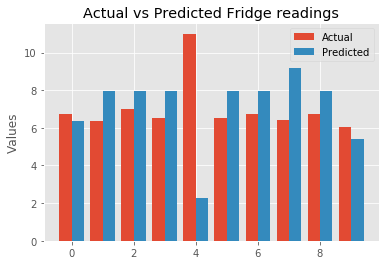

In [570]:
actual=actual.reshape([len(actual)])
predictions=predictions.reshape([len(predictions)])
Y1 = actual[30:40]
Y2 = predictions[30:40]

X_axis = np.arange(len(Y1))
  
plt.bar(X_axis - 0.2, Y1, 0.4, label = 'Actual')
plt.bar(X_axis + 0.2, Y2, 0.4, label = 'Predicted')
  
# plt.xticks(X_axis, X)
# plt.xlabel("Groups")
plt.ylabel("Values")
plt.title("Actual vs Predicted Fridge readings")
plt.legend()
plt.show()


# Observation 

The Squared mean root error is much lesser than the absolute error. This shows that the outliers are pushing the Absolute error. This seems to be the case because the model has been trained on mean absolute error as loss function and probably mean square error would have performed better.